<a href="https://www.kaggle.com/code/malakalaabiad/skin-tone-classification?scriptVersionId=195731517" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. ***Import Required Libraries***

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 2. ***Load and Organize the Dataset***

In [2]:
# Define the correct dataset directory
dataset_dir = '/kaggle/input/dataset-skin-tone/data_skintone/'

# Update categories based on actual directory names
categories = ['dark', 'light', 'mid-dark', 'mid-light']

# Create directories for train and validation split
train_dir = '/kaggle/working/train'
valid_dir = '/kaggle/working/val'

for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, category), exist_ok=True)

# Load image paths and labels
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(dataset_dir, category)
    for img_name in os.listdir(category_path):
        image_paths.append(os.path.join(category_path, img_name))
        labels.append(category)

# Split data into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Move the images to train and validation directories
for img, label in zip(train_paths, train_labels):
    shutil.copy(img, os.path.join(train_dir, label, os.path.basename(img)))

for img, label in zip(val_paths, val_labels):
    shutil.copy(img, os.path.join(valid_dir, label, os.path.basename(img)))

print("Data has been successfully split and organized.")


Data has been successfully split and organized.


 # 3. ***Data Augmentation and Preprocessing***

In [3]:
# Data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Load train and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 28663 images belonging to 4 classes.
Found 7166 images belonging to 4 classes.


# 4. ***Model Creation Using Transfer Learning (MobileNetV2)***

In [4]:
# Load the MobileNetV2 model with pre-trained ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(categories), activation='softmax')(x)  # 4 classes (dark, light, mid-dark, mid-light)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,573,828 (13.63 MB)

 Trainable params: 1,315,844 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 5. ***Train the Model***

In [5]:
# Check class indices to ensure 4 classes
print("Class indices:", train_generator.class_indices)
print("Number of classes:", train_generator.num_classes)

Class indices: {'dark': 0, 'light': 1, 'mid-dark': 2, 'mid-light': 3}
Number of classes: 4


In [6]:
# Define the dataset directory
dataset_dir = '/kaggle/input/dataset-skin-tone/data_skintone/'

# Fix the directory names manually
# Renaming the folder names
rename_map = {
    'lighten': 'light',
    'mid dark': 'mid-dark',
    'mid light': 'mid-light'
}

for wrong_name, correct_name in rename_map.items():
    wrong_path = os.path.join(dataset_dir, wrong_name)
    correct_path = os.path.join(dataset_dir, correct_name)
    
    # If the wrong directory exists, rename it
    if os.path.exists(wrong_path):
        os.rename(wrong_path, correct_path)

# After renaming, ensure you only have 4 categories: 'dark', 'light', 'mid-dark', 'mid-light'
categories = ['dark', 'light', 'mid-dark', 'mid-light']

# Reorganize the dataset after renaming the directories
train_paths = []
val_paths = []
train_labels = []
val_labels = []

for category in categories:
    category_path = os.path.join(dataset_dir, category)
    for img_name in os.listdir(category_path):
        if img_name.endswith(('.png', '.jpg', '.jpeg')):
            train_paths.append(os.path.join(category_path, img_name))
            train_labels.append(category)

# Split the data into train/validation sets again
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.2, stratify=train_labels)

# Move images to organized directories
train_dir = '/kaggle/working/train'
valid_dir = '/kaggle/working/val'

# Ensure the directories are clear and exist
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, category), exist_ok=True)

for img, label in zip(train_paths, train_labels):
    shutil.copy(img, os.path.join(train_dir, label, os.path.basename(img)))

for img, label in zip(val_paths, val_labels):
    shutil.copy(img, os.path.join(valid_dir, label, os.path.basename(img)))

print("Dataset has been successfully renamed and reorganized!")

Dataset has been successfully renamed and reorganized!


In [7]:
# Data generators with fixed classes
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=categories  # Only 4 classes
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=categories  # Only 4 classes
)

# Check the new class indices to ensure it's correct
print("Class indices after renaming:", train_generator.class_indices)

Found 34389 images belonging to 4 classes.
Found 12892 images belonging to 4 classes.
Class indices after renaming: {'dark': 0, 'light': 1, 'mid-dark': 2, 'mid-light': 3}


In [8]:
# Define the Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# Output layer with 7 classes (since we have 7 categories)
predictions = Dense(7, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Setup Image Data Generators
categories = ['dark', 'light', 'lighten', 'mid dark', 'mid light', 'mid-dark', 'mid-light']

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=categories  # Explicitly passing 7 categories
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=categories  # Explicitly passing 7 categories
)

# Confirm that there are 7 classes
print(f"Class indices: {train_generator.class_indices}")

Found 34389 images belonging to 7 classes.
Found 12892 images belonging to 7 classes.
Class indices: {'dark': 0, 'light': 1, 'lighten': 2, 'mid dark': 3, 'mid light': 4, 'mid-dark': 5, 'mid-light': 6}


In [10]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725733271.318642      83 service.cc:145] XLA service 0x781c94001700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725733271.318724      83 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725733271.318729      83 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   1/1075 ━━━━━━━━━━━━━━━━━━━━ 4:08:58 14s/step - accuracy: 0.2500 - loss: 1.7533

I0000 00:00:1725733277.310598      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 432s 390ms/step - accuracy: 0.6457 - loss: 0.8318 - val_accuracy: 0.7234 - val_loss: 0.6431
Epoch 2/10
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 414s 383ms/step - accuracy: 0.7350 - loss: 0.5960 - val_accuracy: 0.7688 - val_loss: 0.5359
Epoch 3/10
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 410s 379ms/step - accuracy: 0.7638 - loss: 0.5351 - val_accuracy: 0.7884 - val_loss: 0.4813
Epoch 4/10
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 410s 379ms/step - accuracy: 0.7804 - loss: 0.4905 - val_accuracy: 0.7879 - val_loss: 0.4800
Epoch 5/10
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 405s 375ms/step - accuracy: 0.7982 - loss: 0.4585 - val_accuracy: 0.8041 - val_loss: 0.4383
Epoch 6/10
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 410s 379ms/step - accuracy: 0.8039 - loss: 0.4482 - val_accuracy: 0.8345 - val_loss: 0.3787
Epoch 7/10
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 408s 377ms/step - accuracy: 0.8111 - loss: 0.4251 - val_accuracy: 0.8276 - val_loss: 0.3925
Epoch 8/10
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 409s 378ms/step - accuracy: 0.8

# 6. ***Visualize Training Performance***

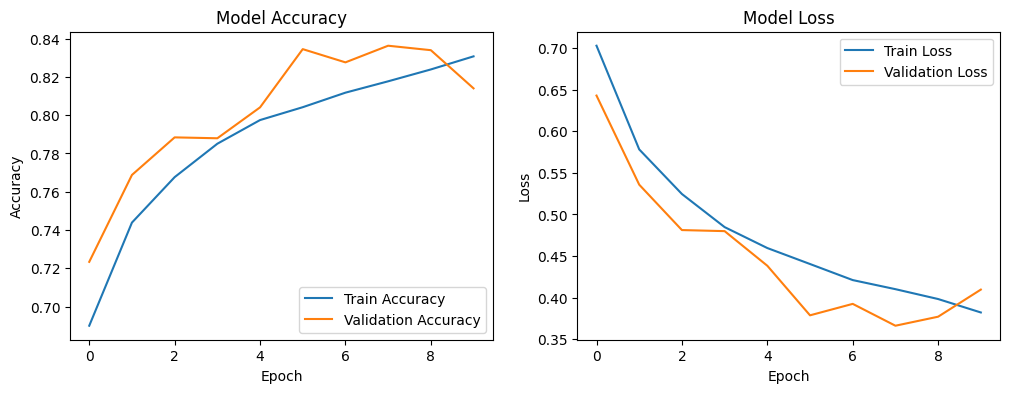

In [11]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

# 7. ***Evaluate the Model***

In [12]:
# Evaluate the model on validation data
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")

403/403 ━━━━━━━━━━━━━━━━━━━━ 29s 71ms/step - accuracy: 0.8402 - loss: 0.3654
Validation Accuracy: 83.63%


# 8. ***Confusion Matrix and Classification Report***

403/403 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step
Unique predicted classes: [0 1 5 6]
Unique true classes: [0 1 5 6]


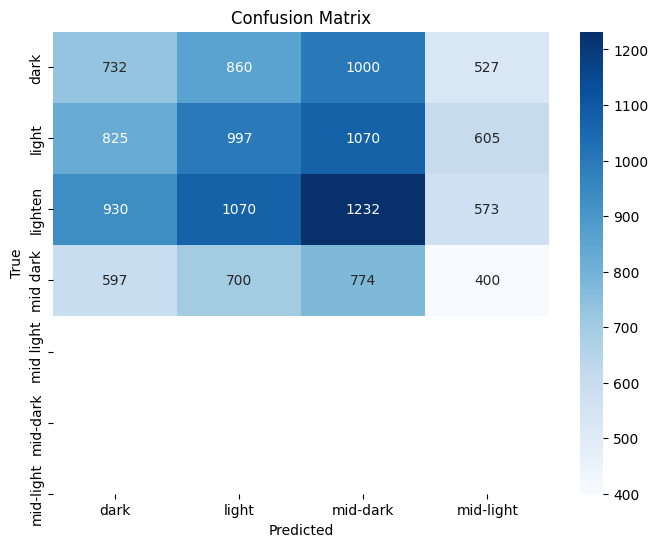

              precision    recall  f1-score   support

        dark       0.24      0.23      0.24      3119
       light       0.27      0.29      0.28      3497
    mid-dark       0.30      0.32      0.31      3805
   mid-light       0.19      0.16      0.17      2471

    accuracy                           0.26     12892
   macro avg       0.25      0.25      0.25     12892
weighted avg       0.26      0.26      0.26     12892



In [13]:
# Predict the classes on validation data
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true classes
y_true = validation_generator.classes

# Check unique predicted and true classes
unique_pred_classes = np.unique(y_pred)
unique_true_classes = np.unique(y_true)

print(f"Unique predicted classes: {unique_pred_classes}")
print(f"Unique true classes: {unique_true_classes}")

# Adjust target names to match actual predicted classes
# This ensures the classification report will reflect only the predicted classes
actual_categories = [categories[i] for i in unique_pred_classes]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actual_categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report with adjusted labels
print(classification_report(y_true, y_pred, labels=unique_pred_classes, target_names=actual_categories))


# 9. ***Save the Model***

In [14]:
# Save the trained model
model.save('/kaggle/working/skin_tone_model.h5')

# 10. ***Inference***

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


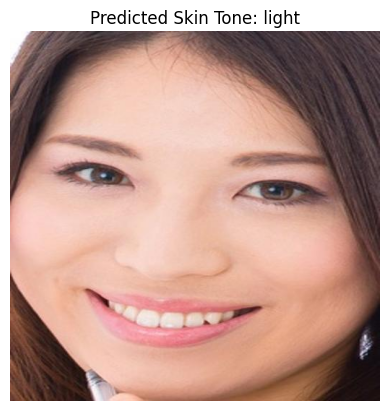

Predicted Skin Tone Class: light


In [15]:
# Load and preprocess the image
img_path = '/kaggle/input/dataset-skin-tone/data_skintone/light/10015832.jpg'  # Replace with actual path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Predict skin tone
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f'Predicted Skin Tone: {categories[predicted_class]}')
plt.axis('off')  # Hide axis for better visualization
plt.show()

print(f'Predicted Skin Tone Class: {categories[predicted_class]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


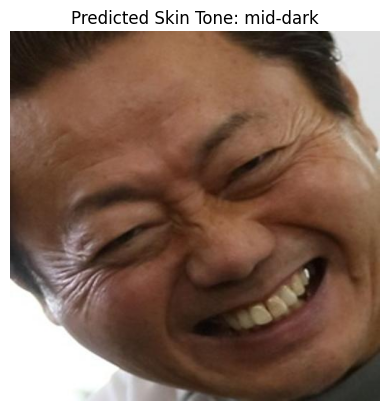

Predicted Skin Tone Class: mid-dark


In [16]:
# Load and preprocess the image
img_path = '/kaggle/input/dataset-skin-tone/data_skintone/mid-dark/24284023.jpg'  # Replace with actual path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Predict skin tone
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f'Predicted Skin Tone: {categories[predicted_class]}')
plt.axis('off')  # Hide axis for better visualization
plt.show()

print(f'Predicted Skin Tone Class: {categories[predicted_class]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


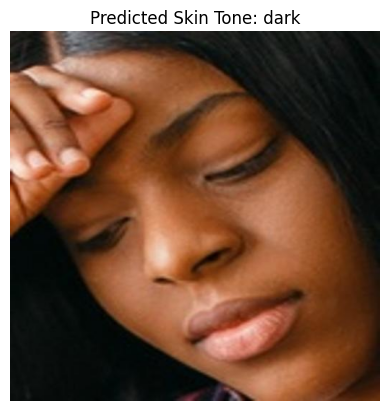

Predicted Skin Tone Class: dark


In [17]:
# Load and preprocess the image
img_path = '/kaggle/input/dataset-skin-tone/data_skintone/dark/50072179.jpg'  # Replace with actual path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Predict skin tone
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f'Predicted Skin Tone: {categories[predicted_class]}')
plt.axis('off')  # Hide axis for better visualization
plt.show()

print(f'Predicted Skin Tone Class: {categories[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


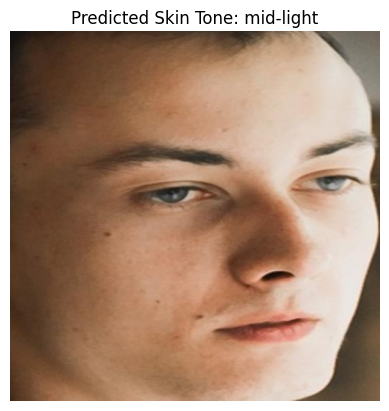

Predicted Skin Tone Class: mid-light


In [18]:
# Load and preprocess the image
img_path = '/kaggle/input/dataset-skin-tone/data_skintone/mid-light/100013282.jpg'  # Replace with actual path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Predict skin tone
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f'Predicted Skin Tone: {categories[predicted_class]}')
plt.axis('off')  # Hide axis for better visualization
plt.show()

print(f'Predicted Skin Tone Class: {categories[predicted_class]}')